In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb

In [2]:
# Load pretrained VGG16 model (Feature Extractor)
vgg16_model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_model.h5")
vgg16_model = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('flatten').output)
for layer in vgg16_model.layers:
    layer.trainable = False

In [3]:
# Data directories
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"


In [4]:
# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [5]:
# Feature extraction function
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

# Extract features using VGG16
train_features, train_labels = extract_features(train_generator, vgg16_model)
test_features, test_labels = extract_features(test_generator, vgg16_model)

54/54 [==============================] - 559s 10s/step


In [6]:
# Standardization
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)
print(f"Original feature dimensions: {train_features_scaled.shape[1]}")

Original feature dimensions: 25088


In [7]:
# Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95)
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)
print(f"Reduced feature dimensions (PCA): {train_features_pca.shape[1]}")

Reduced feature dimensions (PCA): 3354


In [8]:
# Optimized XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8,
    colsample_bytree=0.8, reg_lambda=1, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'
)
xgb_classifier.fit(train_features_pca, train_labels)

C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [9]:
# Evaluate XGBoost classifier
test_predictions = xgb_classifier.predict(test_features_pca)
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy with PCA and XGBoost: {accuracy:.4f}")

Test Accuracy with PCA and XGBoost: 0.8132


In [10]:
print("Classification Report with PCA:")
print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))


Classification Report with PCA:
              precision    recall  f1-score   support

      BENIGN       0.84      0.51      0.63       542
   MALIGNANT       0.81      0.95      0.88      1182

    accuracy                           0.81      1724
   macro avg       0.82      0.73      0.75      1724
weighted avg       0.82      0.81      0.80      1724



In [11]:
# Save models
vgg16_model.save(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\vgg16_with_xgboost_pca.h5')
joblib.dump(pca, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl')
joblib.dump(xgb_classifier, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\xgboost_classifier_model.pkl')
print("Models saved successfully.")

C:\Users\K M SASTRY\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Models saved successfully.


1/1 [==============================] - 1s 864ms/step


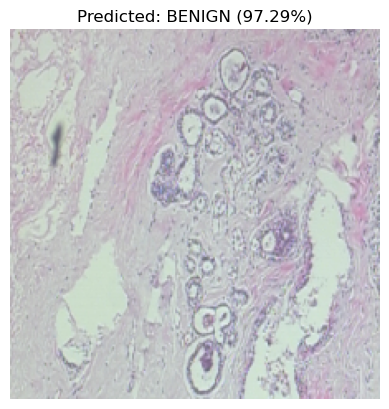

Prediction Probabilities:
BENIGN: 97.29%
MALIGNANT: 2.71%


In [14]:
# Function for single image prediction
def predict_image(image_path, model, xgb_classifier, class_indices):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    features = model.predict(img_array)
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)

    prediction = xgb_classifier.predict(features_pca)
    probabilities = xgb_classifier.predict_proba(features_pca)

    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    predicted_probabilities = probabilities[0]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({max(predicted_probabilities) * 100:.2f}%)")
    plt.show()

    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), predicted_probabilities):
        print(f"{class_label}: {prob * 100:.2f}%")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\adenosis\SOB_B_A_14-22549AB\40X\SOB_B_A-14-22549AB-40-001.png"
predict_image(image_path, vgg16_model, xgb_classifier, train_generator.class_indices)

1/1 [==============================] - 1s 880ms/step


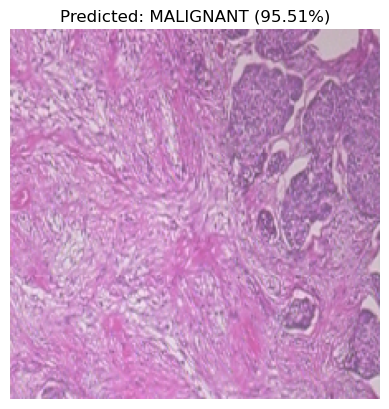

Prediction Probabilities:
BENIGN: 4.49%
MALIGNANT: 95.51%


In [13]:
# Function for single image prediction
def predict_image(image_path, model, xgb_classifier, class_indices):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    features = model.predict(img_array)
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)

    prediction = xgb_classifier.predict(features_pca)
    probabilities = xgb_classifier.predict_proba(features_pca)

    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    predicted_probabilities = probabilities[0]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({max(predicted_probabilities) * 100:.2f}%)")
    plt.show()

    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), predicted_probabilities):
        print(f"{class_label}: {prob * 100:.2f}%")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\ductal_carcinoma\SOB_M_DC_14-2523\40X\SOB_M_DC-14-2523-40-016.png"
predict_image(image_path, vgg16_model, xgb_classifier, train_generator.class_indices)